__Capstone Project - The Battle of Neighborhoods:__

This solution is an attempt to leverage __Four Square Location Service Provider API__ to address a unique problem applying learnings from earlier practical sessions. 

__Problem Intuition:__

Mr.John is 65 year old person who has decided to __move-in to an apartment__ with his wife Mrs.John to a new location among the below considerations in city of Toronto:

- Downtown Toronto
- East Toronto
- West Toronto
- Central Toronto

One key requirement for this beautiful old couple is the __vicinity of Hospitals__ from their new neighbourhood. Both of them have pre exisiting medical conditions. 

Mr.John - a __heart patient__ and his requirement is that the new location should be nearer to __heart speciality hospitals.__

Mrs.John has been visiting __Toronto General Hospitals__ for past few years and she needs atleast one among these hospitals accessible from the new location. 

Apart from this condition, they are flexible enough to handle other requirements. 

They need our help to __suggest them an apt location__ as near as possible according to above conditions, so that they can move without any hesitation and also continue to take their treatments in this old age without any hassle. 

__Importing necessary Libraries:__

In [1]:
import pandas as pd
from pandas import json_normalize
#!pip install geocoder
import geocoder
#!pip install geopy
from geopy.geocoders import Nominatim
import folium # map rendering library
import requests #REST operation
import matplotlib as mpl
import matplotlib.pyplot as plt

__Creating a Dataframe with Toronto Neighbourhood data:__ 

There are multiple ways to extract a table data from a webpage like __BeautifulSoup__ library. This can be applied to more complex cases of extraction and formatting data is necessary. 

As the table is available already, the quick way to access it ina dataframe is by applying __pandas.read_html( ):__

We extracted the first table in html page by pd.read_html('link')[0]

In [2]:
toronto_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
toronto_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


The Location data is organised in __three__ columns. Postal Code, Major Areas called __Boroughs__ and multiple __neighbourhoods__ in the Boroughs. 

As part of initial data cleaning, Rows without borough values are not considered. Removing missing values:

In [3]:
#Ignore without a borough
#toronto_df.drop(toronto_df.loc[toronto_df['Borough'] == 'Not assigned'])
toronto_df = toronto_df[toronto_df['Borough'] != 'Not assigned'].reset_index(drop=True)
toronto_df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
toronto_df.shape

(103, 3)

We now have 103 rows of data from original dataset. We require the GPS coordinates - Latitude and Longitude of these places. They can be accessed using any geocoding library. Some of them required persistant connectivity establishment. As we gathered them from earlier lab sessions, we read them from a CSV file.

Read __Coordinates__ details from CSV into a dataframe. 

This file contains latitude and longitude based on Postal code. We can __merge__ it to our existing dataframe using the common column - __Postal Code.__

In [5]:
coordinates_df = pd.read_csv('/Users/baraths/Documents/DataScience_Course_Online/Data Science - Full Courses/Jupyter Notebook files/Geospatial_Coordinates.csv')
coordinates_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
toronto_df = toronto_df.merge(coordinates_df, on='Postal Code')
toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


According to the Location requirement from Mr.John, we slice it and reduce scope to only those __boroughs from problem statement:__ Downtown Toronto, East Toronto, West Toronto & Central Toronto. 

One easy way to do that is filter Boroughs - with only those values that contain 'Toronto':

In [7]:
#Get Borough which contains string toronto - Slicing to reduce count
toronto_df = toronto_df[toronto_df['Borough'].str.contains("Toronto")].reset_index(drop=True)
toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


As a quick verification we can check __unique__ values:

In [8]:
toronto_df['Borough'].unique()

array(['Downtown Toronto', 'East Toronto', 'West Toronto',
       'Central Toronto'], dtype=object)

__Creating the Map and Plotting from above locations:__

The above dataframe was plotted to get an overall idea of the __neighbourhoods__ distribution and scope we are looking at: By clicking any of them, we can understand which is located where - using the Popup added. 

Even basic interactive features help in understanding our data clearly. 

The coordinates are determined using __Nominatim function from geopy:__

In [9]:
#Get lat and lon of location: 
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="toronto_explorer") #some agent name for format
location = geolocator.geocode(address) #apply geocode inside Nominatim object
#print(location) #actual location

latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


The Map is plotted using __Folium and Circular markers__ are inserted for each neighbourhood.
The __zoom_start__ keyword is extremely useful to set the correct scale of Zoom over our map. 

In [10]:
# create map of Toronto using latitude and longitude values - from narrow down neighborhoods:
map_torronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_torronto)  
    
map_torronto

__Plot to Show Number of Beighbourhoods in each Borough:__

Boroughs are major areas which contains multiple neighbourhoods. By doing an EDA on how they are distributed among our 4 boroughs, we can infer the data more precisely and firm up our understanding:

In [11]:
grp = toronto_df.groupby('Borough').count()
grp = grp['Neighbourhood']

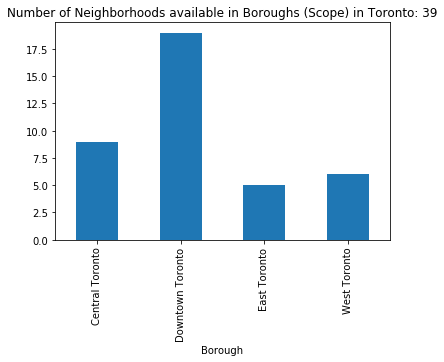

In [12]:
grp.plot(kind = 'bar')
plt.title('Number of Neighborhoods available in Boroughs (Scope) in Toronto: '+str(toronto_df.shape[0]))
plt.show()

We can see that __Downtown Toronto__ consists of major neighbourhoods. We can keep this as reference. 

__Access Four Square API Location Service Provider:__

By creating a Developer account, we have got Following credentials:

- CLIENT_ID
- CLIENT_SECRET

We can apply them to connect with the service provider:

In [13]:
CLIENT_ID = 'VHDJ4AITZWVPERLLXXLARXLWTBVKJMPHDO1PQMENORJ1R5Q2' # your Foursquare ID
CLIENT_SECRET = 'G3FTTGEVNZCPFXLNSK5MZJBV4DC12Q3JCZWCR5RBAKEQT0HT' # your Foursquare Secret
#ACCESS_TOKEN = 'SNPKEDJV1HNCC0JAAWEKA3LF0X3KSTRPJUPQNAYC3BBDLSX0' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

neighborhood_latitude = toronto_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_df.loc[0, 'Neighbourhood'] # neighborhood name

#print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name,neighborhood_latitude, neighborhood_longitude))

Your credentails:
CLIENT_ID: VHDJ4AITZWVPERLLXXLARXLWTBVKJMPHDO1PQMENORJ1R5Q2
CLIENT_SECRET:G3FTTGEVNZCPFXLNSK5MZJBV4DC12Q3JCZWCR5RBAKEQT0HT


By applying one of the places from Downtown toronto as a reference, We are using a search query parameter here to search for hospitals very near to our place: 

The keywords search_query, LIMIT, radius are applied on the common URL structure and our Connect __URL was created:__

In [14]:
search_query = 'Hospital' #Any type of category
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 #in distance metres


# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT,
search_query)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VHDJ4AITZWVPERLLXXLARXLWTBVKJMPHDO1PQMENORJ1R5Q2&client_secret=G3FTTGEVNZCPFXLNSK5MZJBV4DC12Q3JCZWCR5RBAKEQT0HT&v=20180604&ll=43.6542599,-79.3606359&radius=500&limit=100&query=Hospital'

__Get the Results of the venues by GET results:__

The results of our query are obtained in JSON format using GET request API with all relevant information:

In [15]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fc9bf6198a3b92a7fe0f1bb'},
 'response': {'warning': {'text': 'There aren\'t a lot of results for "Hospital." Try something more general, reset your filters, or expand the search area.'},
  'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'query': 'hospital',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 43.6587599045, 'lng': -79.3544279001486},
   'sw': {'lat': 43.6497598955, 'lng': -79.36684389985142}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c45addf429a0f47b16b4a1e',
       'name': 'Bay Cat Hospital',
       'location': {'address': '525 King St East',
        'lat': 43.655393,
        'lng': -79.35854,
        'labeledLatLngs': [{'label':

Based on Position in JSON, The venue - in our case various Hospitals and category details are collected:

In [16]:
#These 2 cells are common in extraction
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
#Extracting Venues from JSON file:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns by removing . and take last value:
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]


__Find Near by Venues for our selected location:__

Method getNearbyVenues(names, latitudes, longitudes, radius) was created to get nearby venues using the location coordinates. 

In [18]:
#Extracting Venues - for all the Places
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            search_query)
            
        # make the GET request - with the necessary key path
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
%%capture
#Venues in Boroughs - containing string toronto:
toronto_df_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )
#toronto_df_venues.head()

In [21]:
toronto_df_venues.shape

(66, 7)

__Selection of Hospitals in neighbourhood to address problem statement:__

The next step is quite critical. 

We are selecting locations by filtering using the conditions given by Mr and Mrs.John. 

For Mr.John we filter __heart speciality hospitals__ and for Mrs.John we filter __torronto general hospitals__ among the selected venues.

In [22]:
t_heart = toronto_df_venues[toronto_df_venues['Venue'].str.contains('Heart') | toronto_df_venues['Venue'].str.contains('card')]
t_general = toronto_df_venues[toronto_df_venues['Venue'].str.contains('General')]

toronto_df_venues = pd.concat([t_heart,t_general]).reset_index(drop = True)
toronto_df_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Richmond, Adelaide, King",43.650571,-79.384568,"Heart Failure Clinic, Robert McRae Heart Healt...",43.652325,-79.379264,Hospital
1,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,Toronto Western nuclear cardiology,43.653405,-79.405008,Hospital
2,"First Canadian Place, Underground city",43.648429,-79.382280,"Heart Failure Clinic, Robert McRae Heart Healt...",43.652325,-79.379264,Hospital
3,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Toronto General Hospital,43.658762,-79.388292,Hospital
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Toronto General Hospital Emergency Room,43.658426,-79.386462,Hospital
5,Central Bay Street,43.657952,-79.387383,Toronto General Hospital,43.658762,-79.388292,Hospital
6,Central Bay Street,43.657952,-79.387383,R. Fraser Elliot Building - Toronto General Ho...,43.658109,-79.386759,Hospital
7,Central Bay Street,43.657952,-79.387383,Toronto General Hospital Emergency Room,43.658426,-79.386462,Hospital


__Neighborhoods which match:__

In [23]:
#Getting how many places exist based on Neighborhood
grp_nh = toronto_df_venues.groupby('Neighborhood').count()
grp_nh[['Venue']]

,Venue
Neighborhood,
Central Bay Street,3
"First Canadian Place, Underground city",1
"Kensington Market, Chinatown, Grange Park",1
"Queen's Park, Ontario Provincial Government",2
"Richmond, Adelaide, King",1


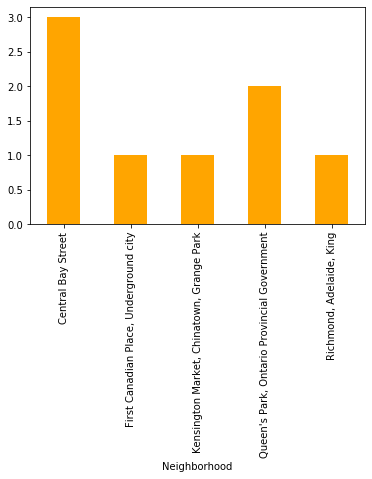

In [24]:
grp_nh = grp_nh['Venue']
grp_nh.plot(kind = 'bar',color = 'orange')
plt.show()

__Geo Locations of Neighbourhoods that contain above Hospitals:__

In order to decide a final location neiighbourhood, the Geo locations of Neighbourhoods containing these hospitals were plotted. We can get a better idea of how they are located:

In [25]:
# Plot geo locations of hospitals filtered using latitude and longitude values
map_torronto_hospital = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, label in zip(toronto_df_venues['Neighborhood Latitude'], toronto_df_venues['Neighborhood Longitude'], toronto_df_venues['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        #fill_color='#3186cc',
        fill_color='blue',
        fill_opacity=0.4,
        parse_html=False).add_to(map_torronto_hospital)  
     
print(type(lat))    
map_torronto_hospital

<class 'float'>


__Calculating Nearest location to all geo locations:__

If accuracy is the key criteria of the project, then we may need to apply the concept of __Great Arcs - Haversine distance__. As our locations in this particular area are not very far from each other, we can roughly consider earth is a plane and estimate the new location by detrmining the __centroid__ of the surrounding geo location coordinates.  

In [26]:
#Calculate the nearest area to all the geolocations
L = [(43.650571, -79.384568), 
 (43.653206, -79.400049), 
 (43.648429, -79.382280),
 (43.662301, -79.389494),
 (43.657952, -79.387383)]

lat = []
long = []
for l in L :
    lat.append(l[0])
    long.append(l[1])

nearest_latitude = float(sum(lat)/len(lat))
nearest_longitude = float(sum(long)/len(long))
print(nearest_latitude, nearest_longitude)

43.6544918 -79.3887548


__Plot Identified location:__
  
Identified location plotted along with the neighbourhoods that contain selected hospitals:

We can choose __radius and zoom__ level accordingly per our scale of estimate

In [27]:
# create map of Manhattan using latitude and longitude values
map_torronto_hospital = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map
for lat, lng, label in zip(toronto_df_venues['Neighborhood Latitude'], toronto_df_venues['Neighborhood Longitude'], toronto_df_venues['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [nearest_latitude, nearest_longitude],
        radius=70,
        popup=label,
        color='red',
        parse_html=False).add_to(map_torronto_hospital)
    
for lat, lng, label in zip(toronto_df_venues['Neighborhood Latitude'], toronto_df_venues['Neighborhood Longitude'], toronto_df_venues['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        #fill_color='#3186cc',
        fill_color='blue',
        fill_opacity=0.4,
        parse_html=False).add_to(map_torronto_hospital)  
    

    
map_torronto_hospital

We can see that __St.Patricks near Central Bay__ would be a great location from where both __Heart Speciality Clinics and Toronto General Hospitals__ are conveniently accessible. Mr and Mrs.John would be happy to move to this kind of a place. 

This project was the First attempt in Data Science - to apply Four Square Location Service provider API to solve a problem we created – to shortlist a location based on Hospitals near by. 
A simple and effective tool for exploring of any geographical location was witnessed. 

This can be extended to many use cases and help people in future. 

__Thank you!__